In [1]:
import sys # system commands
import string as string # string functions4
import math
import numpy as np # numerical tools
import scipy
from scipy import *
from pylab import *
import os
import itertools
import math as maths
from scipy import integrate
from scipy.optimize import curve_fit 
from scipy import interpolate
from scipy.interpolate import interp1d,RectBivariateSpline
from scipy.stats import distributions,pearsonr,chisquare,norm,gaussian_kde,mode
import matplotlib.pyplot as plt
from matplotlib import cm,patches
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy import wcs
from astropy.wcs import WCS
from astropy.visualization import astropy_mpl_style
from reproject.mosaicking import find_optimal_celestial_wcs
from astropy.coordinates import SkyCoord
import glob
from tqdm import tqdm
import shapely
from shapely import geometry
from shapely import LineString
import ot

In [2]:
####################### Useful Functions #########################
c_light = 299792.458 # speed of light in km/s
matter = 0.27
darkenergy=0.73
c_light=299792.458#in km/s
H0=70 #km/s/Mpc
zlens = 0.396
G = 4.3009172706e-3 # pc Msun^-1 (km/s)^2
pcconv = 30856775814914 # km per 1 pc
syear = 365*24*60*60 # seconds in 1 year
rad_per_deg = np.pi/180 # radians per degree
hubparam2 = (H0**2)*(matter*((1+zlens)**3) + darkenergy)
critdens = ((3*hubparam2)/(8*np.pi*G))*(1/(10**12)) # solar mass per pc^3
zeropointRA,zeropointDec = 64.03730721518987,-24.070971485232068 # Some random zero point to be used as a reference
Ddpc = 1110940809.0062053 # in pc
arcsec_pc = Ddpc*(1/206264.80624709636) # pc per 1 arcsec
arcsec_kpc = arcsec_pc*(1/1000) # kpc per 1 arcsec
sigcrit_rescaled = ((c_light**2)/(4*np.pi*G))*(1/Ddpc)*(arcsec_pc**2) # Solar Mass per arsec^2 (Ds/Dds = 1)
zd = 0.396
def hessian(x):
    """
    Calculate the hessian matrix with finite differences
    Parameters:
       - x : ndarray
    Returns:
       an array of shape (x.dim, x.ndim) + x.shape
       where the array[i, j, ...] corresponds to the second derivative x_ij
    """
    x_grad = np.gradient(x) 
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype=x.dtype) 
    for k, grad_k in enumerate(x_grad):
        # iterate over dimensions
        # apply gradient again to every component of the first derivative.
        tmp_grad = np.gradient(grad_k) 
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
    return hessian
def RADEC_to_ARCSEC(RA,Dec,zpra,zpdec):
	# Takes you from RA,Dec in observed degrees to arcsec with respect to given zero point zpra,zpdec

	# First convert RA,Dec to real RA,Dec in deg
	RA = (RA-zpra)*np.cos(Dec*rad_per_deg)
	Dec = Dec - zpdec

	# Next convert to arcsec
	x_arc,y_arc = RA*3600,Dec*3600

	return x_arc,y_arc
def ARCSEC_to_RADEC(xarc,yarc,zpra,zpdec):
	# Takes you from arcsec to RA,Dec with respect to given zero point zpra,zpdec

	Dec = (yarc/3600)+zpdec
	RA = ((xarc/3600)/np.cos(Dec*rad_per_deg))+zpra
	# RA = (xarc/3600)+zpra

	return RA,Dec

In [3]:
#################### DEFINE GRID ############################
gridsize = 100 # We will use 100x100 grid for all models
xlow,ylow,xhigh,yhigh = -70,-70,71,71
nx = (xhigh-xlow)/gridsize
ny = (yhigh-ylow)/gridsize
xrang = np.arange(xlow,xhigh,nx)
yrang = np.arange(ylow,yhigh,ny)
x,y = np.meshgrid(xrang,yrang)

In [5]:
####### FITS Files #######
bergsize=2000 # Bergamini23 size
## THIS IS MY PERSONAL PATH, EDIT TO YOUR DIRECTORY WHERE FILES ARE KEPT
fitspath = '/Users/derek/Desktop/UMN/Research/MACSJ0416/imagefits' 
Nim = [237,237,95,101,116,96,97,102,236,303,343,198,202,94] # Number of Images used in each model
compamodels = ['Perera24','Bergamini23','Keeton20','Williams18','CATS16','Diego18','Sharon17','Caminha16','MARS24',
			   'Rihtarsic24','Diego23','Richard21','Glafic17','Zitrin15'] # Model Names
modeltype=['G','P','P','G','P','H','P','P','FF','P','H','P','P','P'] # Parametric, Grale, Hybrid, or Freeform
kappamodels = ['%s/kappa_FF00_Perera25.fits'%fitspath,
			   '%s/Mass_zc0.396_Npix%s.fits'%(fitspath,bergsize),
			   '%s/hlsp_frontier_model_macs0416_keeton_v4_kappa.fits'%fitspath,
			   '%s/hlsp_frontier_model_macs0416_williams_v4_kappa.fits'%fitspath,
			   '%s/hlsp_frontier_model_macs0416_cats_v4.1_kappa.fits'%fitspath,
			   '%s/hlsp_frontier_model_macs0416_diego_v4.1_kappa.fits'%fitspath,
			   '%s/hlsp_frontier_model_macs0416_sharon_v4_kappa.fits'%fitspath,
			   '%s/hlsp_frontier_model_macs0416_caminha_v4_kappa.fits'%fitspath,
			   '%s/result_kappa_MACSJ0416_w_header_MARS23.fits'%fitspath,
			   '%s/macs0416clu-kappa-best-100mas_Rihtarsic24.fits'%fitspath,
			   '%s/kappa_FF00_Perera25.fits'%fitspath, ### PLACEHOLDER SINCE Diego23 DOES NOT HAVE KAPPA
			   '%s/MACS0416_MUSE_DR_v1.1_kappa_Richard21.fits'%fitspath,
			   '%s/hlsp_frontier_model_macs0416_glafic_v4_kappa.fits'%fitspath,
			   '%s/hlsp_frontier_model_macs0416_zitrin-nfw_v3_kappa.fits'%fitspath]

In [6]:
xm,ym = np.meshgrid(np.linspace(xlow,xhigh,gridsize),np.linspace(ylow,yhigh,gridsize))
xmrang = xm[0]
ymrang = ym.T[0]
def getKappa(kappafile):
	ind = compamodels.index(kappafile)
	if compamodels[ind]=='Diego23':
		Dspc,Ddspc = 956013768.6823735,800926431.7451072 # at z=9
		with fits.open("%s/AlphaY_DdsDs1_arcsec_MACS0416_Case6.fits"%fitspath) as hdu:
			alphax = hdu[0].data*(Ddspc/Dspc)
			xwcs2 = wcs.WCS(hdu[0].header)
		with fits.open("%s/AlphaX_DdsDs1_arcsec_MACS0416_Case6.fits"%fitspath) as hdu:
			alphay = hdu[0].data*(Ddspc/Dspc)
			ywcs2 = wcs.WCS(hdu[0].header)
		pixcoords = np.array([[i,j] for i in tqdm(range(alphax.shape[0])) for j in range(alphay.shape[1])])
		ra,dec = xwcs2.all_pix2world(pixcoords,1).T
		xb,yb = RADEC_to_ARCSEC(ra,dec,zeropointRA,zeropointDec) 
		xb,yb = xb.reshape(alphax.shape[0],alphax.shape[1]),yb.reshape(alphay.shape[0],alphax.shape[1])
		xblow,yblow,xbhigh,ybhigh = xb.min(),yb.min(),xb.max(),yb.max()
		nbx = (xbhigh-xblow)/alphax.shape[0]
		nby = (ybhigh-yblow)/alphay.shape[1]
		xbrang = np.linspace(xblow,xbhigh,alphax.shape[0])#np.arange(xblow,xbhigh,nbx)
		ybrang = np.linspace(yblow,ybhigh,alphay.shape[1])#np.arange(yblow,ybhigh,nby)
		# alphax,alphay = alphax*(nbx/206264.80624709636),alphay*(nby/206264.80624709636)
		psixx = np.gradient(alphax)[0]
		psiyy = np.gradient(alphay)[1]
		psixy = np.gradient(alphax)[1]
		psiyx = np.gradient(alphay)[0]
		kap = 0.5*(psixx + psiyy)
		kap = np.rot90(kap.T,3)/(nbx)
		gam1 = 0.5*(psixx - psiyy)
		gam1 = np.rot90(gam1.T,3)/(nbx)
		gam2 = psixy
		gam2 = np.rot90(gam2.T,3)/(nbx)
		magntest = 1/((1.0-kap)*(1.0-kap) - (gam1**2) - (gam2**2))

		massinterp = RectBivariateSpline(ybrang,xbrang,kap*(Dspc/Ddspc)) # Kappa
		kappa = np.array([massinterp.ev(xmrang[i],ymrang[j]) for i in tqdm(range(len(xmrang))) for j in range(len(ymrang))]).reshape(gridsize,gridsize)

		# muinterp = RectBivariateSpline(ybrang,xbrang,magntest) # Magnification
		# xmu,ymu = np.meshgrid(np.linspace(xlow,xhigh,magn.shape[0]),np.linspace(ylow,yhigh,magn.shape[1]))
		# xmurang = xmu[0]
		# ymurang = ymu.T[0]
		# magn2 = np.array([muinterp.ev(xmurang[i],ymurang[j]) for i in tqdm(range(len(xmurang))) for j in range(len(ymurang))]).reshape(gridsize+1,gridsize+1)

	else:	
		with fits.open(kappamodels[ind]) as hdu:
			data = hdu[0].data
			wcs2 = wcs.WCS(hdu[0].header)
			data = np.where(np.isnan(data)==False,data,0)
		pixcoords = np.array([[i,j] for i in tqdm(range(data.shape[1])) for j in range(data.shape[0])])
		ra,dec = wcs2.all_pix2world(pixcoords,1).T
		xb,yb = RADEC_to_ARCSEC(ra,dec,zeropointRA,zeropointDec) 
		xb,yb = xb.reshape(data.shape[0],data.shape[1]),yb.reshape(data.shape[0],data.shape[1])
		xblow,yblow,xbhigh,ybhigh = xb.min(),yb.min(),xb.max(),yb.max()
		nbx = (xbhigh-xblow)/data.shape[0]
		nby = (ybhigh-yblow)/data.shape[1]
		xbrang = np.linspace(xblow,xbhigh,data.shape[1])#np.arange(xblow,xbhigh,nbx)
		ybrang = np.linspace(yblow,ybhigh,data.shape[0])#np.arange(yblow,ybhigh,nby)
		massinterp = RectBivariateSpline(ybrang,xbrang,np.rot90(data.T,3)) # Kappa
		kappa = np.array([massinterp.ev(xmrang[i],ymrang[j]) for i in tqdm(range(len(xmrang))) for j in range(len(ymrang))]).reshape(gridsize,gridsize)
		if compamodels[ind]=='Bergamini23':
			kappa = ((kappa*1e12)*(arcsec_kpc**2))/sigcrit_rescaled

	return kappa

Run loop below as a test. It will error here
Below loop calculates Median Percent Difference, Frechet Distance, and Wasserstein Distance for all models
It will split the sample into the necessary image bins

100%|████████████████████████████████████| 100/100 [00:00<00:00, 723.88it/s]


Perera24 vs. Bergamini23


100%|███████████████████████████████████████| 10/10 [00:00<00:00, 10.47it/s]


9.790306797684156 0.18176693298336666 0.21412708691918542 



FileNotFoundError: [Errno 2] No such file or directory: '/Users/derek/Desktop/UMN/Research/MACSJ0416/imagefits/result_kappa_MACSJ0416_w_header_MARS23.fits'

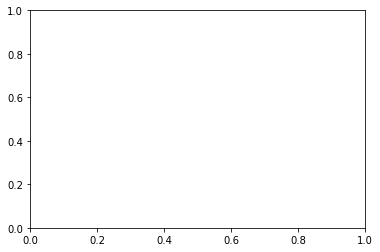

In [20]:
fig5,ax5=subplots(1,facecolor='w', edgecolor='k')
angle=45
lensrect1 = patches.Rectangle((-20,-69),118,63,angle=angle,edgecolor='r', facecolor='none')
ax5.add_patch(lensrect1)
blx,bly = lensrect1.get_x(),lensrect1.get_y() # Bottom left x, Bottom left y (the vertex at which points are rotated)
brx,bry = blx + lensrect1.get_width()*np.cos(angle*(np.pi/180)),bly + lensrect1.get_width()*np.sin(angle*(np.pi/180)) # Bottom right x, Bottom right y
tlx,tly = blx - lensrect1.get_height()*np.cos((90-angle)*(np.pi/180)),bly + lensrect1.get_height()*np.sin((90-angle)*(np.pi/180)) # Top Left x, Top left y
thetaprime = np.arctan(lensrect1.get_height()/lensrect1.get_width())*(180/np.pi)
trx = blx + np.sqrt(lensrect1.get_height()**2 + lensrect1.get_width()**2)*np.cos((angle+thetaprime)*(np.pi/180)) #  Top Right x
tr_y = bly + np.sqrt(lensrect1.get_height()**2 + lensrect1.get_width()**2)*np.sin((angle+thetaprime)*(np.pi/180)) # Top Right y

def fitline(x,m,b):
	return m*np.array(x)+b
def straightline(x,x1,y1,x2,y2):
	# Equation of a straight line between 2 points (x1,y1) and (x2,y2)
	slope = (y2-y1)/(x2-x1)
	y = slope*(x-x2) + y2
	return y

binarycompa,paramcompa,pvffcompa = [[],[]],[[],[]],[[],[]] 
binarypdiffs,binaryFD,binaryWD = [[],[]],[[],[]],[[],[]]
parampdiffs,paramFD,paramWD = [[],[]],[[],[]],[[],[]]
pvffpdiffs,pvffFD,pvffWD = [[],[]],[[],[]],[[],[]]
binaryalpha=[[],[]]
binarynumdiffs=[[],[]]
allpdiffs,allFD,allWD,absnumdiff=[],[],[],[]
allpvffpdiffs,allpvffFD,allpvffWD,allpvffnumdiffs=[],[],[],[]
allparampdiffs,allparamFD,allparamWD,allparamnumdiffs=[],[],[],[]
for i in range(len(compamodels)):
	kappa1 = getKappa(compamodels[i])
	# kapspline1 = RectBivariateSpline(xmrang,ymrang,kappa1.T)
	# kap1ims = kapspline1.ev(xarc,yarc) # Evaluate kappa only at image positions
	N1 = Nim[i]
	for j in range(len(compamodels)):
		if j<=i:
			continue
		N2 = Nim[j]
		if ((N1<=150) and (N2>150)):
			continue
		if ((N1>150) and (N2<=150)):
			continue		
		kappa2 = getKappa(compamodels[j])
		# kapspline2 = RectBivariateSpline(xmrang,ymrang,kappa2.T)
		# kap2ims = kapspline2.ev(xarc,yarc) # Evaluate kappa only at image positions
		print('%s vs. %s'%(compamodels[i],compamodels[j]))
		absnumdiff.append(abs(N1-N2))

		### Percent Difference within Rectangle
		percentdiff = (abs(kappa1-kappa2)/((abs(kappa1+kappa2))/2))*100
		percentdiff = np.where(percentdiff < 120, percentdiff, nan)
		percentdiffrect=[]
		xrect,yrect = [],[]
		kap1,kap2 = [],[]
		for m in range(len(xmrang)):
			bottomliney = straightline(xmrang[m],blx,bly,brx,bry)
			topliney = straightline(xmrang[m],tlx,tly,trx,tr_y)
			rightliney = straightline(xmrang[m],brx,bry,trx,tr_y)
			leftliney = straightline(xmrang[m],blx,bly,tlx,tly)
			for n in range(len(ymrang)):
				if ((ymrang[n]>=bottomliney) and (ymrang[n]>=leftliney) and (ymrang[n]<=topliney) and (ymrang[n]<=rightliney)):
					kap1.append(kappa1[m][n])
					kap2.append(kappa2[m][n])
				if ((0.5*(kappa1[m][n]+kappa2[m][n])>=0.5) and (0.5*(kappa1[m][n]+kappa2[m][n])<2.0)):
					percentdiffrect.append(percentdiff[m][n])
					xrect.append(xmrang[m])
					yrect.append(ymrang[n])
		percentdiffrect=np.array(percentdiffrect)
		percentdiffrect = np.array([percentdiffrect[i] for i in range(len(percentdiffrect)) if np.isnan(percentdiffrect[i])==False])
		pdiff=np.median(percentdiffrect)
		allpdiffs.append(pdiff)

		# # At Image Positions
		# percentdiff = (abs(kappa1-kappa2)/((abs(kappa1+kappa2))/2))*100
		# percentdiff = np.where(percentdiff < 120, percentdiff, nan)
		# pdiff = np.median(percentdiff)
        # kap1,kap2 = kappa1,kappa2

		### Frechet Distance
		pfit12, results12 = curve_fit(fitline,kap1,kap2)
		err_pfit12=np.sqrt(np.diag(results12))
		pfit21, results21 = curve_fit(fitline,kap2,kap1)
		err_pfit21=np.sqrt(np.diag(results21))
		sline = LineString([(0, 0), (3, 3)])
		line1 = LineString([(0, pfit12[1]), (3, fitline(3,pfit12[0],pfit12[1]))])
		line2 = LineString([(0, pfit21[1]), (3, fitline(3,pfit21[0],pfit21[1]))])
		fd1,fd2 = shapely.frechet_distance(sline, line1),shapely.frechet_distance(sline, line2)
		fd = min(fd1,fd2)
		allFD.append(fd)

		### Wasserstein Distance
		wasserstein=np.array([ot.sliced_wasserstein_distance(kappa1,kappa2,n_projections=1000) for i in tqdm(range(10))])
		wd = np.mean(wasserstein)
		allWD.append(wd)

		print('%s %s %s \n'%(pdiff, fd, wd))
		# if ((modeltype[i]=='P') and (modeltype[j]=='P')):
		# 	allparampdiffs.append(pdiff)
		# 	allparamFD.append(fd)
		# 	allparamWD.append(wd)
		# 	allparamnumdiffs.append(abs(N1-N2))
		# if (((modeltype[i]!='P') and (modeltype[j]=='P')) or ((modeltype[i]=='P') and (modeltype[j]!='P'))):
		# 	allpvffpdiffs.append(pdiff)
		# 	allpvffFD.append(fd)
		# 	allpvffWD.append(wd)
		# 	allpvffnumdiffs.append(abs(N1-N2))

		if ((N1<=150) and (N2<=150)):
			binarycompa[0].append('%sv%s'%(compamodels[i],compamodels[j]))
			binarypdiffs[0].append(pdiff)
			binaryFD[0].append(fd)
			binaryWD[0].append(wd)
			binarynumdiffs[0].append(abs(N1-N2))
			if fd == fd1:
				binaryalpha[0].append(pfit12[0])
			if fd == fd2:
				binaryalpha[0].append(pfit21[0])
			if ((modeltype[i]=='P') and (modeltype[j]=='P')):
				paramcompa[0].append('%sv%s'%(compamodels[i],compamodels[j]))
				parampdiffs[0].append(pdiff)
				paramFD[0].append(fd)
				paramWD[0].append(wd)
			if (((modeltype[i]=='G') and (modeltype[j]=='P')) or ((modeltype[i]=='P') and (modeltype[j]=='G'))):
				pvffcompa[0].append('%sv%s'%(compamodels[i],compamodels[j]))
				pvffpdiffs[0].append(pdiff)
				pvffFD[0].append(fd)
				pvffWD[0].append(wd)

		if ((N1>150) and (N2>150)):
			binarycompa[1].append('%sv%s'%(compamodels[i],compamodels[j]))
			binarypdiffs[1].append(pdiff)
			binaryFD[1].append(fd)
			binaryWD[1].append(wd)
			binarynumdiffs[1].append(abs(N1-N2))
			if fd == fd1:
				binaryalpha[1].append(pfit12[0])
			if fd == fd2:
				binaryalpha[1].append(pfit21[0])
			if ((modeltype[i]=='P') and (modeltype[j]=='P')):
				paramcompa[1].append('%sv%s'%(compamodels[i],compamodels[j]))
				parampdiffs[1].append(pdiff)
				paramFD[1].append(fd)
				paramWD[1].append(wd)
			if (((modeltype[i]=='G') and (modeltype[j]=='P')) or ((modeltype[i]=='P') and (modeltype[j]=='G'))):
				pvffcompa[1].append('%sv%s'%(compamodels[i],compamodels[j]))
				pvffpdiffs[1].append(pdiff)
				pvffFD[1].append(fd)
				pvffWD[1].append(wd)